# House Prices: Advanced Regression Techniques
Joanna Broniarek
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
---------------

Before starting project I decided to read some articles:
1. https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

    + Select Data: Integrate data, de-normalize it into a dataset, collect it together.
    + Preprocess Data: Format it, clean it, sample it so you can work with it.
    + Transform Data: Feature Engineer happens here.
    + Model Data: Create models, evaluate them and tune them.
    + 
2. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

2. 6 top factors  that influence a home’s value: https://www.inman.com/2017/08/07/6-factors-that-influence-a-homes-value/
3. https://www.rochesterrealestateblog.com/what-factors-influence-the-sale-price-of-a-home/
_______________

Data tidying
1. removed rows with > 90% NA
2. removed outliers (var X > mean(X) + 3*sd(X)) ----> Z-score method
3. normalization…

Feature engineering
1. created feature MyFoo defined as XYZ that captures aspect ABC
…

Modelization
1. linear regression
2. clustering on features A, B, C

Training
1. average of 10-folds cross validation
2. LASSO model selection

### Reguly:

1- the submission consists of (1) a submission to the Kaggle competition, and (2) a submission to the Project gradeable on our server (http://18.184.187.134)

2- for Kaggle, you must submit as a Kaggle Team, and the team name (competition menu -> Team Name) must contain the ID of a team member

3- for our server, you must submit a ZIP file not exceeding 1MB that contains (A) a concise summary, and (B) the main Python or R scripts/notebook and other optional scripts (e.g. your own python module)

4- the summary must be a PDF file, must not exceed 1 page, and must follow the structure in the attached sample file (in particular it must give the Kaggle team name

5- there is no restriction on packages and/or on techniques you can use

6- exam booking dates apply; e.g. to get your project evaluated for the exam call of Jan 18, submit no later than Jan 16. Late submissions will not be considered

7- grading is performed in two stages. First, if the summary and/or scripts are not well organised and understandable, then the project is deemed insufficient. Otherwise, the grade is primarily on the Kaggle score achieved. As a rule of thumb, a score <= .112 means 30/30, a score = .122 means 24/30, a score >= .132 means <= 18/30. Bonuses or penalties can be given on a per-case basis

8- you can resubmit to a later exam call only if you improve significantly your Kaggle score (by at least -1%)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler
# from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sys
# import re
import sklearn_pandas
import numpy as np

#Remember to change the path!!!

# path = r'C:\Users\Asia\Desktop\FUW17-18\kaggle-titanic-master\category_encoders-1.2.6'
# sys.path.insert(0, path)
# from category_encoders import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split

import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

### Reading CSV file as Dataframe:

In [3]:
data_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/train.csv")
# test_df = pd.read_csv("C:/Users/Asia/fdf_kaggle_project/test.csv")

### EDA - Exploratory Data Analysis

Firstly, I provided some analysis of our data.

In [4]:
len(data_df.columns)

81

In [5]:
data_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


I noticed that the dataset consists of 38 numerical columns of 81 all. 
Morover, some columns contain missing data, i.e."LotFrontage", "MasVnrArea".

------------------------

**The label which I would like to predict is 'SalePrice'. Let's look closer to this column.**

In [6]:
# Basic information:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

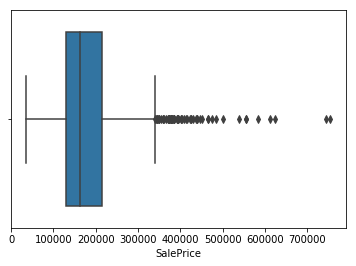

In [7]:
sns.boxplot(data_df['SalePrice'])

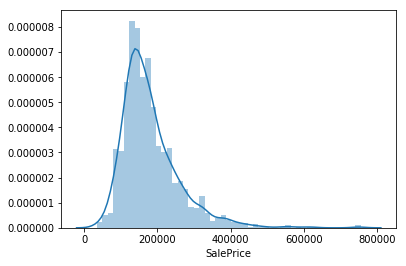

In [8]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

**It is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k. **

In [9]:
#Skeweness
data_df['SalePrice'].skew()

1.8828757597682129

## Data tidying // PREPROCESSING

+  **Removing columns with Nan values**

Checking the fraction of Nan values in dataframe. The columns with value > 0.9 will be removed.

Getting names of columns to drop out:

In [10]:
col_nan = data_df.isna().sum() / data_df.shape[0]
drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.9) if i==True]]
drop_out_columns

Index(['Alley', 'PoolQC', 'MiscFeature'], dtype='object')

In [11]:
# Dropping columns with more than 90 % of Nan values
data_df = data_df.drop(drop_out_columns, axis=1)

Drop "Id" column:

In [12]:
data_df = data_df.drop('Id', axis=1)

Removing rows where SalePrice is NAN:

In [13]:
data_df = data_df.dropna(subset=['SalePrice'])

+ **Removing outliers**

I will use **Z-score method** to detect the outliers. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.  

I will set a **threshold = 3** to identify outliers.
$$ z = \frac{x - \mu}{\sigma} $$


In [14]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]  
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

In [15]:
# REMOVING OUTLIERS -- choose appropriate values!
clear_data, removed_data = remove_outliers(data_df, threshold = 3, removed=True, columns=['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'FullBath', 'SalePrice'])

Number of removed rows = 36


In [16]:
clear_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


## Log transform skewed features

In [17]:
# Logarithm transformation of the label column:
# clear_data["SalePrice"] = np.log1p(clear_data["SalePrice"])

In [18]:
# logarithm transformation of skewed numeric features:
num_features = clear_data.select_dtypes(include=['int64','float64']).columns
num_features = [feat for feat in num_features if feat != 'SalePrice'] #without considering SalePrice

skewed_features = clear_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index

clear_data[skewed_features] = np.log1p(clear_data[skewed_features])

## Replacing missing values in numerical columns
+ **SimpleImputer - Imputation transformer for completing missing values.**

    + strategy : The imputation strategy.
    
        If “mean”, then replace missing values using the mean along the axis.
        
        If “median”, then replace missing values using the median along the axis.
        
        If “most_frequent”, then replace missing using the most frequent value along the axis.

In [19]:
# num_features

Generating numerical features as input to DataFrameMapper.  

The dataframe **imputed_data** contains only columns after transformation

In [20]:
numeric_features = sklearn_pandas.gen_features(columns=[num_features], classes=[{'class': SimpleImputer, 'strategy': 'most_frequent', 'missing_values' : np.nan}])
mapper = sklearn_pandas.DataFrameMapper(numeric_features)
imputed_features = mapper.fit_transform(clear_data.copy())
imputed_df = pd.DataFrame(imputed_features, index=clear_data.index, columns=num_features)

In [21]:
imputed_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,4.110874,4.189655,9.042040,7.0,1.791759,2003.0,2003.0,5.283204,6.561031,0.0,...,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2.0,2008.0
1,3.044522,4.394449,9.169623,6.0,2.197225,1976.0,1976.0,0.000000,6.886532,0.0,...,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5.0,2007.0
2,4.110874,4.234107,9.328212,7.0,1.791759,2001.0,2002.0,5.093750,6.188264,0.0,...,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9.0,2008.0
3,4.262680,4.110874,9.164401,7.0,1.791759,1915.0,1970.0,0.000000,5.379897,0.0,...,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2.0,2006.0
4,4.110874,4.442651,9.565284,8.0,1.791759,2000.0,2000.0,5.860786,6.486161,0.0,...,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12.0,2008.0


## Label Encoding - Categorical to numeral

In [41]:
# Select category features
cat_feats = clear_data.select_dtypes(include=['object']).columns
cat_feats

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [23]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","No"), 
                  ("Electrical", "None"),
                  ("BsmtCond","No"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"),
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"),
                  ("Fence","No"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("Utilities","AllPub")]

In [24]:
def none_transform(df, conversion_list):
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [25]:
clear_data = none_transform(clear_data, none_conversion)

As **Neighbourhood** according to a lot of sources have a big influence on house prices, I would like to look closer to this feature.


In [57]:
# Unique values:
clear_data.Neighborhood.unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'ClearCr', 'NPkVill', 'StoneBr', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

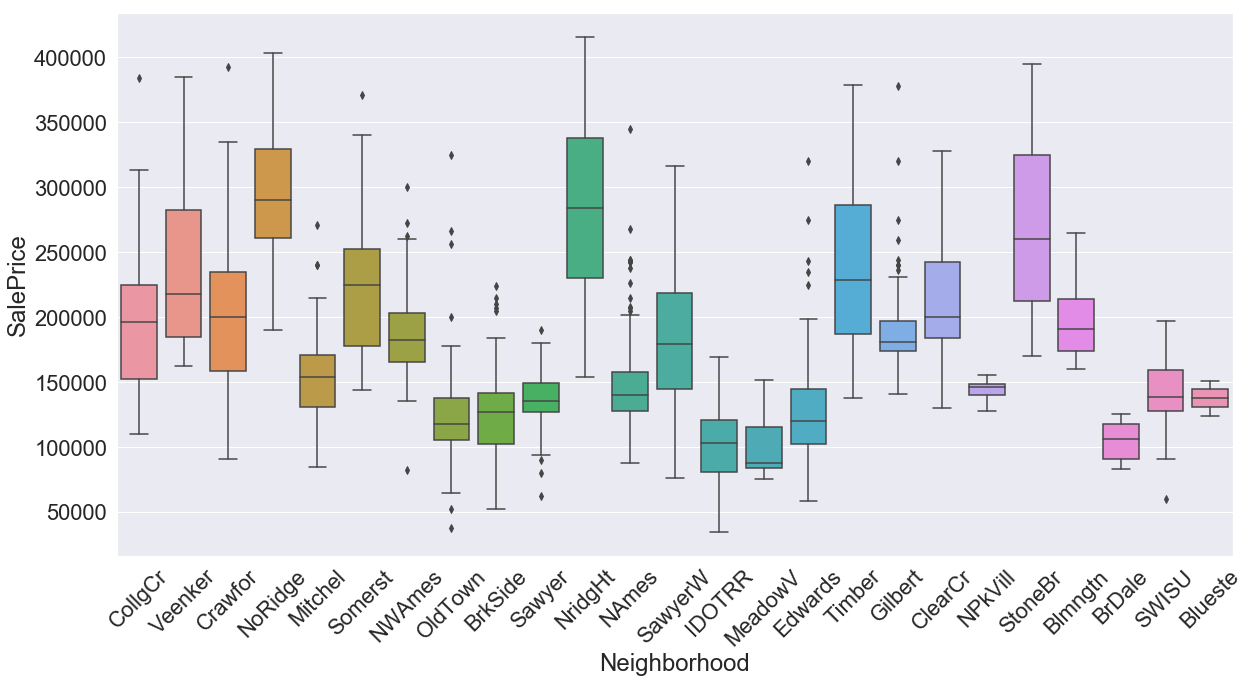

In [56]:
# Boxplot Neighborhood vs. SalePrice
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
sns.boxplot(y="SalePrice", x = "Neighborhood", data = clear_data)
plt.xticks(rotation=45)

Some of the neighborhoods seems to be more expensive than the others, so I decided to create a specific Mapper for **Neighborhood** column. 

Those with names: 'StoneBr', 'NridgHt', 'NoRidge' I will convert as 2, with names:'MeadowV', 'IDOTRR', 'BrDale' as 1 and the rest as 0. 

In [70]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    ''' NewNeigh is a column with new numerical values'''
    
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 1, 'IDOTRR' : 1, 'BrDale' : 1 ,
                        'CollgCr': 0, 'Veenker' : 0, 'Crawfor' : 0,
                        'Mitchel' : 0, 'Somerst' : 0, 'NWAmes' : 0,
                        'OldTown' : 0, 'BrkSide' : 0, 'Sawyer' : 0, 
                        'NAmes' : 0, 'SawyerW' : 0, 'Edwards' : 0,
                        'Timber' : 0, 'Gilbert' : 0, 'ClearCr' : 0,
                        'NPkVill' : 0, 'Blmngtn' : 0, 'SWISU' : 0,
                        'Blueste': 0}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        @np.vectorize
        def get_label(t):
            return self.neighborhoodsmap[t]
        return X.assign(NewNeigh=get_label(X.Neighborhood)).as_matrix()

The dataframe **transformed_df** contains only columns after transformation from categorical into numerical.

In [71]:
# TRANSFORMATION INTO NUMERICS

cat_features = sklearn_pandas.gen_features([[c] for c in cat_feats.tolist() if c != "Neighborhood"], 
                                           [LabelEncoder])
title_features = [(['Neighborhood'], [NeighborhoodTransformer()], 
                   {'alias': 'Neigh_ID'})]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(cat_features + title_features)

# Transformation
transformed_feats = label_encoder.fit_transform(clear_data.copy())
transformed_df = pd.DataFrame(transformed_feats, index=clear_data.index, columns=cat_feats)

# Show first rows:
transformed_df.head()

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: ['Neighborhood']: 'numpy.ndarray' object has no attribute 'assign'

### Concatenate 'imputed_df' and 'transformed_df' into one dataframe.

In [27]:
preprocessed_df = pd.concat([transformed_df, imputed_df],axis=1)
preprocessed_df['SalePrice'] = clear_data['SalePrice']

In [28]:
# Check if all columns where considered
set(clear_data.columns) == set(preprocessed_df.columns)

True

All columns were considered. OF course, The SalePrice was not transformed.

## Creating new features

In [248]:
# Total Squere Feet for house
preprocessed_df["TotalSqrtFeet"] = preprocessed_df["GrLivArea"] + preprocessed_df["TotalBsmtSF"]
# Total number of bathrooms
preprocessed_df["TotalBaths"] = preprocessed_df["BsmtFullBath"] + (preprocessed_df["BsmtHalfBath"]  * .5) + preprocessed_df["FullBath"] + (preprocessed_df["HalfBath"]* .5)

In [293]:
corr = preprocessed_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.800505
GrLivArea        0.687875
TotalBaths       0.653683
GarageCars       0.648183
GarageArea       0.629204
TotalSqrtFeet    0.620515
TotalBsmtSF      0.620143
YearBuilt        0.575275
1stFlrSF         0.570790
FullBath         0.547207
YearRemodAdd     0.537604
TotRmsAbvGrd     0.481901
Fireplaces       0.481261
OpenPorchSF      0.454746
GarageYrBlt      0.415985
MasVnrArea       0.408646
Foundation       0.408028
LotArea          0.372299
WoodDeckSF       0.331831
LotFrontage      0.326006
HalfBath         0.287327
CentralAir       0.273197
GarageCond       0.268172
Electrical       0.255167
PavedDrive       0.252349
BsmtFullBath     0.238822
GarageQual       0.236873
SaleCondition    0.234927
Neighborhood     0.195304
                   ...   
Street           0.043963
PoolArea         0.035519
LandContour      0.011958
Condition2       0.011395
MasVnrType      -0.013775
Utilities       -0.014997
BsmtHalfBath    -0.027102
YrSold      

In [250]:
#TODO: for columns like "KitchenQual" change encoding into ordered labels. !!!!

### Feature selection considering selected aspects

Let's look at features that are the most correlated with Sale Price

In [292]:
corrmat = preprocessed_df.corr()
# print only those with absolute correlation more than 0.5:
corrmat[np.abs(corrmat['SalePrice']) > 0.4]['SalePrice']

ExterQual       -0.624351
Foundation       0.408028
BsmtQual        -0.593052
HeatingQC       -0.416791
KitchenQual     -0.561573
GarageType      -0.470560
GarageFinish    -0.440594
OverallQual      0.800505
YearBuilt        0.575275
YearRemodAdd     0.537604
MasVnrArea       0.408646
TotalBsmtSF      0.620143
1stFlrSF         0.570790
GrLivArea        0.687875
FullBath         0.547207
TotRmsAbvGrd     0.481901
Fireplaces       0.481261
GarageYrBlt      0.415985
GarageCars       0.648183
GarageArea       0.629204
OpenPorchSF      0.454746
SalePrice        1.000000
TotalSqrtFeet    0.620515
TotalBaths       0.653683
Name: SalePrice, dtype: float64

Let's make **heatmap of correlations** to get the overall look at data.
As the number of features is too big to clearly visualise the heatmap, I decided to show only the correlations bigger than 0.5.

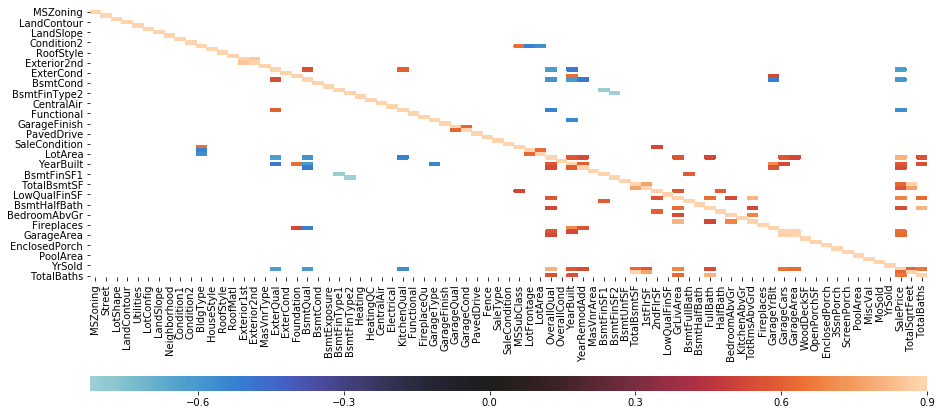

In [253]:
# Correlation matrix

# f, ax = plt.subplots(figsize=(15, 15))
grid_kws = {"height_ratios": (.9, .05), "hspace": .7}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws,figsize=(15, 7))
sns.heatmap(corrmat[np.abs(corrmat) > 0.5], vmax=.9, square=False, center=0, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})

I found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ There is a strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ The same situation as above is between **TotRmsAbvGrd** and **GrLivArea**. What seems to be rational. 
+ Morover, some columns seems to be useless in terms of the house price prediction (like PavedDrive or RoofStyle ..), so I remove them for further analysis. 

**Accordinig to above analysis and some read articles about the house prices I selected a few features that seems to be useful for the house price predition:**
+ **Quality** : OverallQual
+ **Size** : GrLivArea (better correlation than TotalSqrtFeet)
+ **Bathrooms** : TotalBaths
+ **Garage** : GarageCars (little better than GarageArea or GarageType)
+ **Kitchen** : KitchenQual

In [259]:
# interesting_columns = ['OverallQual','YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'FullBath']

interesting_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBaths', "KitchenQual"]

In [255]:
# SELECTING FEATURES
selected_features_df = preprocessed_df[interesting_columns + ["SalePrice"]]
selected_features_df.head()

,OverallQual,GrLivArea,GarageCars,TotalBaths,KitchenQual,SalePrice
0,7.0,7.444833,2.0,3.039721,2,208500
1,6.0,7.141245,2.0,2.346574,3,181500
2,7.0,7.488294,2.0,3.039721,2,223500
3,7.0,7.448916,3.0,1.693147,2,140000
4,8.0,7.695758,3.0,3.039721,2,250000


In [210]:
# selected_features_df.describe()

# Modelization
-----------------------------------

### Splitting train and test dataset

In [217]:
# # ALL FEATURES
# print(" The number of features = {}".format(preprocessed_df.shape[1]-1))
# y = preprocessed_df.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(preprocessed_df.drop(['SalePrice'], axis=1), y, test_size = 0.2, random_state = 0)

 The number of features = 78


In [256]:
# SELECTED FEATURES
print(" The number of features = {}".format(selected_features_df.shape[1]-1))
y = selected_features_df.SalePrice
X_train, X_test, y_train, y_test = train_test_split(selected_features_df.drop(['SalePrice'], axis=1), y, test_size = 0.2, random_state = 0)

 The number of features = 5


In [257]:
print(" Shapes:")
{k : v.shape for k, v in {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}.items()}

 Shapes:


{'X_test': (285, 5),
 'X_train': (1139, 5),
 'y_test': (285,),
 'y_train': (1139,)}

### Standarizing 
Standarizing by StandardScaler

In [264]:
notnormalized_frs = list(set(interesting_columns).intersection(set(num_features)))

stdSc = StandardScaler()
X_train.loc[:, notnormalized_frs] = stdSc.fit_transform(X_train.loc[:, notnormalized_frs])
X_test.loc[:, notnormalized_frs] = stdSc.transform(X_test.loc[:, notnormalized_frs])

In [263]:
# stdSc = StandardScaler()
# X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])
# X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

#### Linear Regression

I am doing linear regression on all features in my dataframe. 

In [286]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [291]:
lr.score(X_train, y_train)

0.7874115961314969

In [290]:
lr.score(X_test, y_test)

0.7673700076954799

In [266]:
lr.intercept_

179725.5059188382

Text(0.5,1,'Prices vs. Predicted Prices')

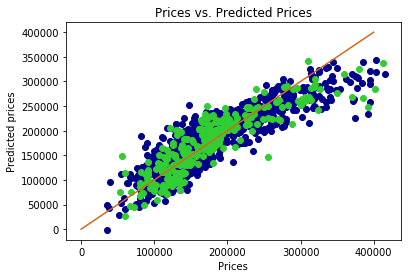

In [287]:
# TODO: Predicted are green
plt.scatter(y_train, y_train_pred, c = "darkblue")
plt.scatter(y_test, y_test_pred, c = "limegreen")
plt.plot([0, 4*10**5], [0, 4*(10**5)], c = "chocolate")
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

I can calculate Mean Squared Error:

In [273]:
MSE_train = np.mean((y_train_pred - y_train)**2)
MSE_test = np.mean((y_test_pred - y_test)**2)
print("Mean Squared Error for train set : {:.3f}".format(MSE_train))
print("Mean Squared Error for test set : {:.3f}".format(MSE_test))

Mean Squared Error for train set : 921375163.944
Mean Squared Error for test set : 1091355639.742


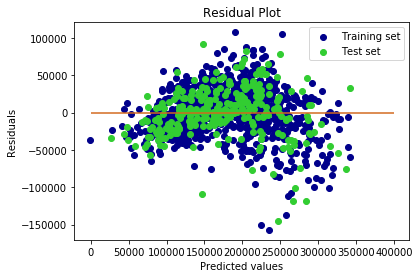

In [280]:
# Residual plot:
plt.scatter(y_train_pred, y_train_pred - y_train, c = "darkblue", label = "Training set")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "limegreen", label = "Test set")
plt.hlines(y = 0, xmin = 0, xmax = 4*(10**5), color = "chocolate")
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")

Conclusions:
+ overfitting 
+ houses with lower price are not good estimated
+ residuals: data should be randomly scattered around line zero.


## Correlations

+ Now, I would like to know more about relationships between features

ExterQual       -0.566381
BsmtQual        -0.560613
KitchenQual     -0.503822
GarageType      -0.524244
OverallQual      0.801114
YearBuilt        0.606021
YearRemodAdd     0.564078
TotalBsmtSF      0.613551
1stFlrSF         0.576271
GrLivArea        0.708773
FullBath         0.570740
GarageCars       0.662677
GarageArea       0.634219
SalePrice        1.000000
TotalSqrtFeet    0.613942
TotalBaths       0.680182
Name: SalePrice, dtype: float64

Let's make **heatmap of correlations** to get the overall look at data.

KeyError: True

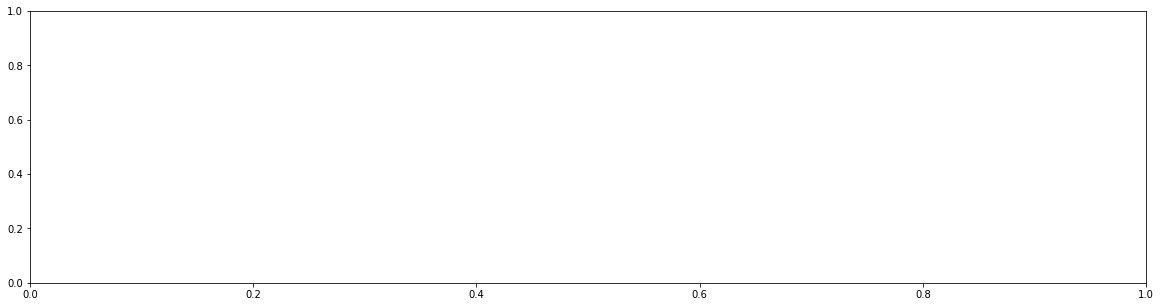

In [178]:
#correlation matrix
# corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corrmat[np.abs(corrmat['SalePrice']) > 0.5], vmax=.9, square=True)

We found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ Strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ the same situation is between TotRmsAbvGrd and GrLivArea. What seems to be rational. 
+ Morover, some columns seems to be useless in terms of the house price prediction, so I remove them for further analysis. 

In [301]:
# Most correlated NUMERICAL columns with the SalePrice column
corrmat[np.abs(corrmat['SalePrice']) > 0.5]['SalePrice']

ExterQual       -0.564041
BsmtQual        -0.560558
KitchenQual     -0.512185
GarageType      -0.524988
OverallQual      0.801885
YearBuilt        0.610159
YearRemodAdd     0.562003
TotalBsmtSF      0.610475
1stFlrSF         0.565575
GrLivArea        0.703826
FullBath         0.580548
GarageCars       0.648056
GarageArea       0.620302
SalePrice        1.000000
TotalSqrtFeet    0.610873
TotalBaths       0.682905
Name: SalePrice, dtype: float64

In [67]:
interesting_columns = ['OverallQual','YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'FullBath']

In [68]:
# SELECTING FEATURES
selected_features_df = clear_data[interesting_columns]
selected_features_df.head()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,7,2003,856,1710,2,2
1,6,1976,1262,1262,2,2
2,7,2001,920,1786,2,2
3,7,1915,756,1717,3,1
4,8,2000,1145,2198,3,2


In [72]:
selected_features_df.describe()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars,FullBath
count,1424.00000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000
mean,6.04073,1970.954354,1033.542135,1480.608848,1.745787,1.547051
std,1.30829,29.940044,386.479688,457.921732,0.731759,0.534704
min,2.00000,1872.000000,0.000000,438.000000,0.000000,0.000000
25%,5.00000,1954.000000,793.000000,1125.000000,1.000000,1.000000
50%,6.00000,1972.000000,980.500000,1452.000000,2.000000,2.000000
75%,7.00000,2000.000000,1267.250000,1744.500000,2.000000,2.000000
max,10.00000,2010.000000,2223.000000,3086.000000,4.000000,3.000000


array([-0.26077702,  0.86350235, -0.4010023 , ..., -0.63120408,
       -0.32531227,  1.65987682])

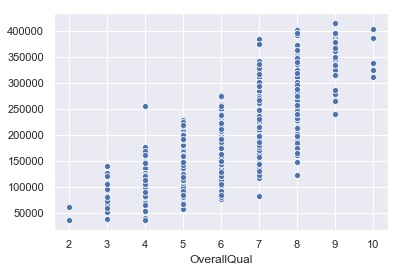

In [73]:
#scatterplot
clear_data = pd.DataFrame(clear_data)
sns.set()
ax = sns.scatterplot(x="OverallQual", y=y, data=clear_data)

In [77]:
num_features = sklearn_pandas.gen_features(columns=[['OverallQual'], ['TotalBsmtSF'],['GrLivArea'],['GarageCars'],['FullBath']], classes=[SimpleImputer, StandardScaler])
mapper = sklearn_pandas.DataFrameMapper(num_features)
scaled_features = mapper.fit_transform(selected_features_df.copy())
scaled_features_df = pd.DataFrame(scaled_features, index=selected_features_df.index, columns=['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars', 'FullBath'])
# scaled_features_df = scaled_features_df.reset_index()

In [78]:
selected_features_df.head()

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,7,2003,856,1710,2,2
1,6,1976,1262,1262,2,2
2,7,2001,920,1786,2,2
3,7,1915,756,1717,3,1
4,8,2000,1145,2198,3,2


In [79]:
scaled_features_df.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,0.733482,-0.459544,0.501116,0.347523,0.847401
1,-0.031143,0.591333,-0.477561,0.347523,0.847401
2,0.733482,-0.293889,0.667141,0.347523,0.847401
3,0.733482,-0.718381,0.516407,1.714574,-1.023450
4,1.498107,0.288494,1.567174,1.714574,0.847401


In [83]:
# LINEAR REGRESSION

X = scaled_features_df[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF']].as_matrix()

reg = LinearRegression()
reg.fit(X, y)

print("Score: {0} \nCoeff: {1}".format(reg.score(X, y), reg.coef_))

Score: 0.8004657631901989 
Coeff: [27797.64806622 20024.16269033 11416.41321534 15517.87639283]


---------------------
## Test Set Predictions 

In [87]:
# PREPARING TEST SET

test_df = test_df.drop(drop_out_columns, axis=1)
test_df = test_df.drop('Id', axis=1)

In [91]:
selected_features_test_df = test_df[['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars','FullBath']]
scaled_features_test = mapper.fit_transform(selected_features_test_df.copy())
scaled_features_test_df = pd.DataFrame(scaled_features_test, index=selected_features_test_df.index, columns=['OverallQual', 'TotalBsmtSF','GrLivArea','GarageCars', 'FullBath'])

In [93]:
scaled_features_test_df.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageCars,FullBath
0,-0.751101,-0.370808,-1.215588,-0.988013,-1.028720
1,-0.054877,0.639144,-0.323539,-0.988013,-1.028720
2,-0.751101,-0.266876,0.294508,0.301623,0.773083
3,-0.054877,-0.271395,0.243004,0.301623,0.773083
4,1.337571,0.528434,-0.424487,0.301623,0.773083


In [95]:
X_test = scaled_features_test_df[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF']].as_matrix()

In [96]:
# PREDICTIONS ON TEST SET
reg.predict(X_test)

array([112796.17737749, 165684.4142192 , 159370.40190488, ...,
       153041.05424609, 102177.71977052, 230489.19178417])

--------------------

In [97]:
from sklearn.cluster import KMeans

In [112]:
kmeans = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(X)
kmeans.labels_
# kmeans.predict([[0, 0], [4, 4]])
# array([0, 1], dtype=int32)
# kmeans.cluster_centers_
# array([[1., 2.],
#        [4., 2.]])

array([1, 3, 1, ..., 1, 0, 0])

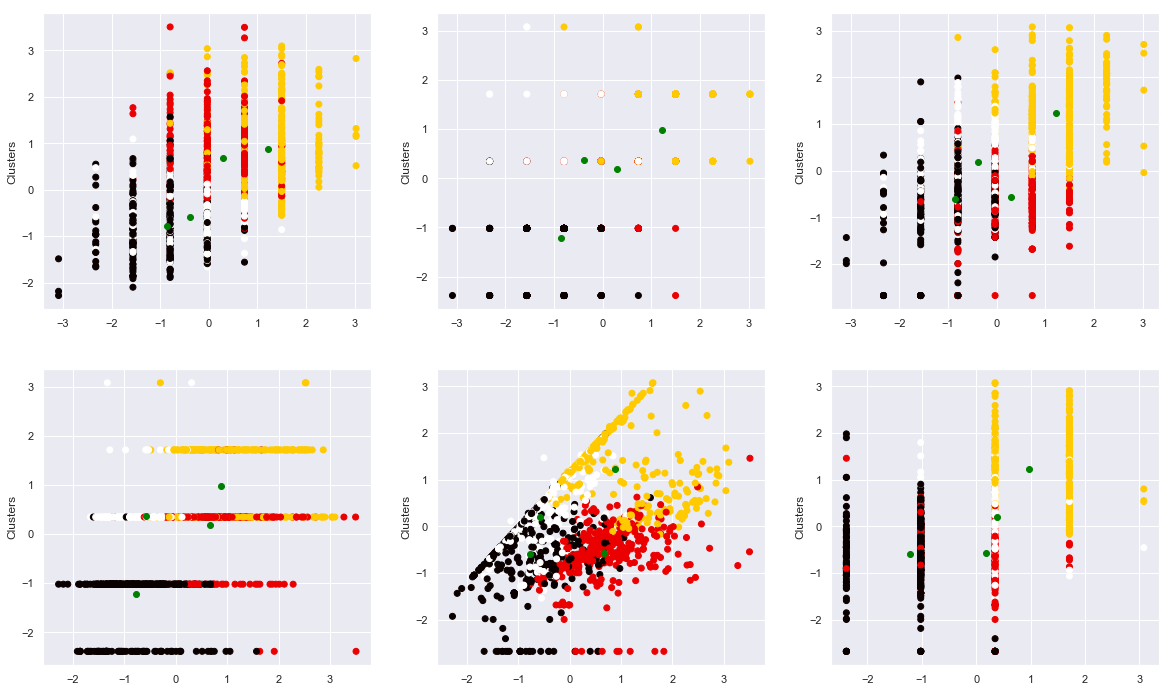

In [116]:
plt.figure(figsize=(20,12))
couples = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for i in range(1, 7):
    plt.subplot(2, 3, i)
    a, b = couples[i-1]
    plt.scatter(X[:,a],X[:,b], c=kmeans.labels_, cmap='hot')
    plt.scatter(kmeans.cluster_centers_[:,a] ,kmeans.cluster_centers_[:,b], color='green')
    plt.ylabel("Clusters")
#     plt.xlabel(str(x_labels[a]))

### Neighborhood - categorical to numeral -- Label encoding

In [187]:
nghb = data_df['Neighborhood'].unique()
nghb

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'ClearCr', 'NPkVill', 'StoneBr', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [209]:
data_df['Neighborhood'] = data_df['Neighborhood'].astype('category')
data_df['Neighborhood_num'] = data_df['Neighborhood'].cat.codes
data_df.head()    

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Neighborhood_num
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500,24
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500,5
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000,6
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000,15


### KitchenQual - Label encoding

In [216]:
# kitchen_le = LabelEncoder()
# kitchen_le.fit(list(data_df.loc[:,('KitchenQual')]))
# kitchen_le.classes_
# data_df.loc[:,('KitchenQual')] = kitchen_le.transform(list(data_df.loc[:,('KitchenQual')]))  

In [275]:
# data_df[['KitchenQual']].head()

### Label Encoding

In [290]:
# num_features = sklearn_pandas.gen_features(['LandContour'], StringIndexer)

cat_features = [(['LandContour'], LabelEncoder()), (['KitchenQual'], LabelEncoder()), (['Neighborhood'], LabelEncoder())]
data_pipe = sklearn_pandas.DataFrameMapper(cat_features, df_out=True, input_df=True)
train = data_pipe.fit_transform(data_df, data_df.SalePrice)
data_df['LandContour'] = train['LandContour']
data_df['KitchenQual'] = train['KitchenQual']
data_df['Neighborhood'] = train['Neighborhood']

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [294]:
data_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,3,AllPub,Inside,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,3,AllPub,FR2,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,3,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,3,AllPub,Corner,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,3,AllPub,FR2,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


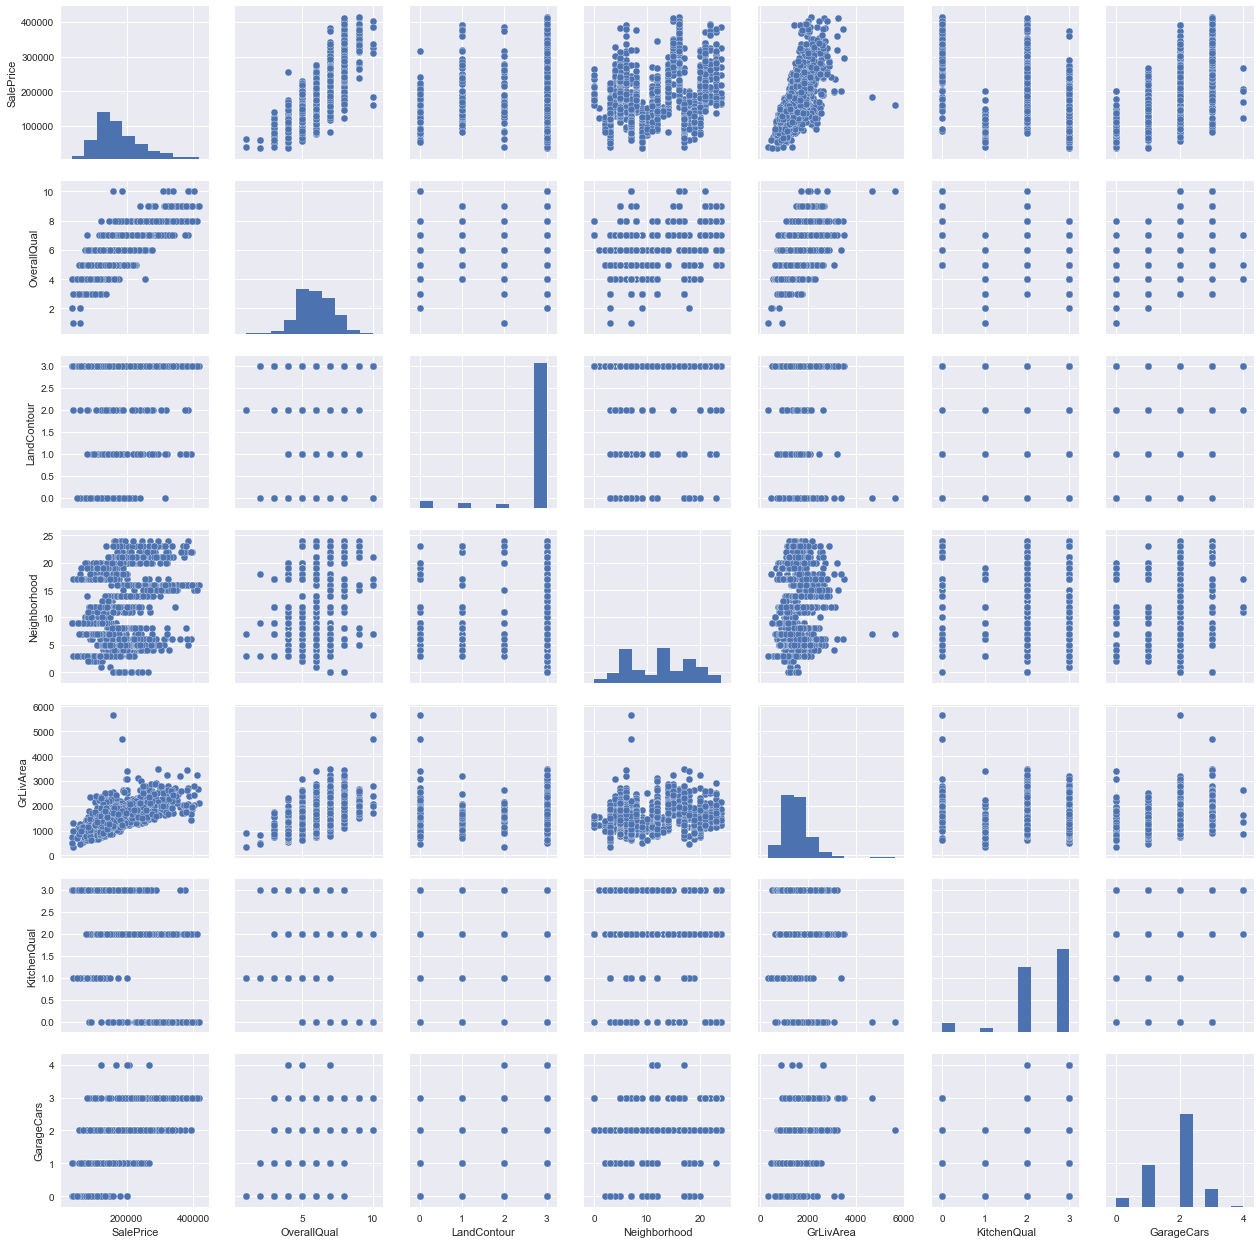

In [295]:
#scatterplot
sns.set()
cols = ["SalePrice", "OverallQual", "LandContour", "Neighborhood", "GrLivArea", "KitchenQual", "GarageCars"]
sns.pairplot(data_df[cols], size = 2.5)
plt.show()

In [ ]:
# numerics = ['int64','float64']
# new_df = data_df.select_dtypes(include=numerics)
# len(new_df.columns)

In [305]:
new_df = data_df[["SalePrice", "OverallQual", "Neighborhood", "GrLivArea", "KitchenQual", "GarageCars"]]

In [313]:
new_df.drop(columns=['SalePrice']).head()

,OverallQual,Neighborhood,GrLivArea,KitchenQual,GarageCars
0,7,5,1710,2,2
1,6,24,1262,3,2
2,7,5,1786,2,2
3,7,6,1717,2,3
4,8,15,2198,2,3


In [300]:
new_df.corr()['SalePrice']

SalePrice       1.000000
OverallQual     0.796343
Neighborhood    0.196283
GrLivArea       0.670485
KitchenQual    -0.548128
GarageCars      0.651158
Name: SalePrice, dtype: float64

### Feature engineering

+ Imputer - Imputation transformer for completing missing values.
''' missing_values : integer or “NaN”, optional (default=”NaN”)

The placeholder for the missing values. All occurrences of missing_values will be imputed. For missing values encoded as np.nan, use the string value “NaN”.

strategy : string, optional (default=”mean”)

The imputation strategy.

If “mean”, then replace missing values using the mean along the axis.
If “median”, then replace missing values using the median along the axis.
If “most_frequent”, then replace missing using the most frequent value along the axis. '''

+ Standarizing by StandardScaler

In [35]:
num_features = sklearn_pandas.gen_features(columns=[['col1'], ['col2'], ['col3']], classes=[Imputer, StandardScaler])
num_features

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[(['col1'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col2'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)]),
 (['col3'],
  [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
   StandardScaler(copy=True, with_mean=True, with_std=True)])]

In [30]:
# num_features = sklearn_pandas.gen_features([['SibSp'], ['Parch'], ['Fare']], [Imputer])

# cat_features = [
#                 (['Pclass'], CategoricalEncoder()),
#                 (['Embarked'], CategoricalEncoder(categories=['C', 'Q', 'S'])),
#                 (['Sex'], CategoricalEncoder(categories=['female']))
#                ]

# ticket_features = [(['Ticket', 'Sex', 'PassengerId'], TicketStats(), {'alias': 'TicketStats'})]

# cabin_features = [(['Cabin'], CabinFeatures(), {'alias': 'Deck'})]

# title_features = [
#                   (['Name', 'Age'], [CleanTitles(), CategoricalImputer(set(CleanTitles.titlemap.values()), Imputer())], {'alias': 'Age'}),
#                   (['Name'], [CleanTitles(), CategoricalEncoder()], {'alias': 'Title'})
#                  ]

# data_pipe = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features + ticket_features, df_out=True, input_df=True)
# data_pipe_no_ticket = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features, df_out=True, input_df=True)

In [ ]:
mapper = DataFrameMapper([(df.columns, StandardScaler())])
scaled_features = mapper.fit_transform(df.copy(), 4)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [235]:
class StringIndexer(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.categories].apply(lambda s: s.cat.codes.replace({-1: len(s.cat.categories)}))

In [80]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
    
    def get_feature_names(self):
        if self.categories is None:
            return [c for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping']]
        else:
            return self.categories
        
    def fit(self, X, y=None):
        try:
            self.onehotencoder_ = OneHotEncoder(cols = list(X.columns), return_df=False, handle_unknown='ignore')
        except AttributeError:
            self.onehotencoder_ = OneHotEncoder(return_df=False, handle_unknown='ignore')
        self.onehotencoder_.fit(X)
        
    def transform(self, X):
        res = self.onehotencoder_.transform(X)
        if self.categories is not None:
            idxs = [i for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping'] if c in set(self.categories)]
            return res[:, idxs]
        return res

Reading the **train.csv** file:

----------
+ "Alley" does not contain a lot of information, mostl;y Nan, so we can drop this column
+ Similar situation is with "PoolQC" and "MiscFeature" columns
+ 

## Correlation 

In [ ]:
#### Now, I would like to know more about relationships between features

Let's make heatmap of correlations to get the overall look at data.

= === ------------------------------

#correlation matrix
corrmat = data_df.corr()
f, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(corrmat, vmax=.9, square=True)

= === ---------------

We found some interesting informations:
+ Some feature like : **OverallQuall, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF**, have quite a high correlation with SalePrice data.
+ Strong correlaction between: **TotalBsmtSF, 1stFlrSF** and between:**GarageCars, GarageArea,**, what can suggest that enough information we can get only taking for instance **GarageCars** and **TotalBsmtSF** instead of all.
+ the same situation is between TotRmsAbvGrd and GrLivArea. What seems to be rational. 
+ sth more? maybe negatively correlated?

-= ---------------= -

 Correlations between features and 'SalePrice'
 spearman_df = pd.DataFrame()
 spearman_df['feature'] = data_df.columns
 spearman_df['spearman'] = [data_df[f].corr(data_df['SalePrice'], 'spearman') for f in data_df.columns]
 sorted_spearman_df = spearman_df.sort_values('spearman')
 plt.figure(figsize=(6, 0.25*len(data_df.columns)))
 sns.barplot(data=sorted_spearman_df, y='feature', x='spearman', orient='h')
 
 -=--=================-------
 
 According to correlation and previously general informations from articles I decided to be focused on selected features like:
+ OverallQual
+ LandContour
+ Neighborhood
+ YearBuilt ??? no
+ GrLivArea
+ KitchenQual
+ Electrical ??? no
+ CentralAir ??? no
+ Fireplaces ??? no
+ GarageCars
+ PoolArea ??? no

## Linear Regression

In [320]:
from sklearn.linear_model import LinearRegression

X = new_df.drop(columns=['SalePrice'])
y = new_df[['SalePrice']]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
# reg.coef_
# reg.intercept_ 
# reg.predict(test)

0.7620599642466808

In [319]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [301]:
# data_df.corr()['SalePrice']

In [302]:
# data_df.columns

In [304]:
# data_df = data_df.drop(columns=['Alley', 'PoolQC', 'MiscFeature'])
# data_df.head()

Lets check correlations and cover of the info between columns about **garage**

In [69]:
garage_df = data_df[["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA


In [49]:
garage_df.dtypes

GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars        int64
GarageArea        int64
GarageQual       object
GarageCond       object
dtype: object

#### Decomposition of Categorical Attributes

In [72]:
# We can convert non-numerical values to some numbers 

from sklearn import preprocessing

le1 = preprocessing.LabelEncoder()
le1.fit(list(garage_df.loc[:,('GarageQual')]))
le1.classes_
garage_df.loc[:,('GarageQual')] = le1.transform(list(garage_df.loc[:,('GarageQual')]))  

le = preprocessing.LabelEncoder()
le.fit(list(garage_df.loc[:,('GarageCond')]))
le.classes_
garage_df.loc[:,('GarageCond')] = le.transform(list(garage_df.loc[:,('GarageCond')]))  

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
garage_df.head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,4,4
1,Attchd,1976.0,RFn,2,460,4,4
2,Attchd,2001.0,RFn,2,608,4,4
3,Detchd,1998.0,Unf,3,642,4,4
4,Attchd,2000.0,RFn,3,836,4,4


In [74]:
garage_df.corr()

,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond
GarageYrBlt,1.000000,0.588920,0.564567,0.310021,0.256680
GarageCars,0.588920,1.000000,0.882475,-0.117061,-0.162246
GarageArea,0.564567,0.882475,1.000000,-0.096674,-0.139104
GarageQual,0.310021,-0.117061,-0.096674,1.000000,0.597030
GarageCond,0.256680,-0.162246,-0.139104,0.597030,1.000000


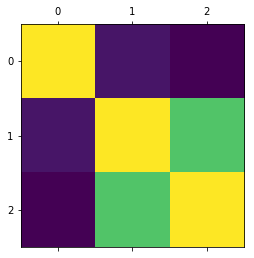

In [47]:
plt.matshow(garage_df.corr())
plt.show()

------------------
At first, I want to analyse the column "MSSubClass"

**MSSubClass:** 
+ Identifies the type of dwelling involved in the sale.

In [22]:
data[["Id", "MSSubClass"]].groupby(by="MSSubClass").count()

,Id
MSSubClass,
20,536
30,69
40,4
45,12
50,144
60,299
70,60
75,16
80,58
